# Data Loading

In [2]:
path1 = "Dataset/gauravduttakiit/banknote/versions/1"

print("Path to dataset files:", path1)


TRAIN_PATH = path1 + "/train.csv"
TEST_PATH = path1 + "/test.csv"

Path to dataset files: Dataset/gauravduttakiit/banknote/versions/1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv(TRAIN_PATH)

In [4]:
df.head()

,VWTI,SWTI,CWTI,EI,Class
0,2.2634,-4.4862,3.6558,-0.612510,0
1,3.2718,1.7837,2.1161,0.613340,0
2,-3.9411,-12.8792,13.0597,-3.312500,1
3,0.5195,-3.2633,3.0895,-0.984900,0
4,2.5698,-4.4076,5.9856,0.078002,0


# Обучение модели DecisionTreeClassifier

## Базовая модель

Наши фичи и таргет

In [6]:
X = df.drop(columns=['Class'])
y = df['Class']

Разделение на трени и тест

In [115]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

Обучение

In [85]:
baseline_tree = DecisionTreeClassifier(random_state=42)
baseline_tree.fit(X_train, y_train)
y_pred_base = baseline_tree.predict(X_valid)

Метрики

In [86]:
acc = accuracy_score(y_valid, y_pred_base)
prec = precision_score(y_valid, y_pred_base)
rec = recall_score(y_valid, y_pred_base)

In [87]:
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)

Accuracy: 0.9818181818181818
Precision: 0.9682539682539683
Recall: 0.9838709677419355


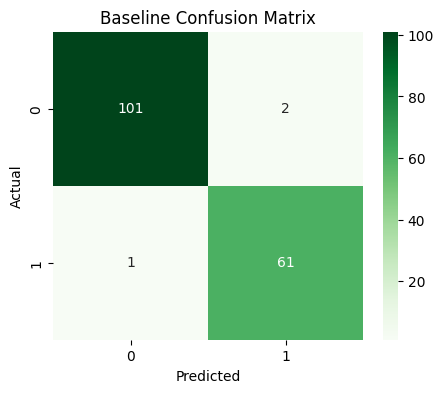

In [88]:
cm = confusion_matrix(y_valid, y_pred_base)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()

## Улучшенная модель

1. Подбор оптимальных параметров
2. Разделение на классы при разбиении на треин и тест

In [108]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [90]:
best_acc = 0
best_model = None
best_params = None


for depth in [2, 3, 4, 5, 7, 10, 15, None]:
    for min_split in [2, 5, 10, 20]:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_split, random_state=42)
        tree.fit(X_train, y_train)
        preds = tree.predict(X_valid)
        score = accuracy_score(y_valid, preds)
        if score > best_acc:
            best_acc = score
            best_model = tree
            best_params = (depth, min_split)


print("\nBest Parameters (Improved Model):", best_params)


Best Parameters (Improved Model): (7, 2)


In [95]:
baseline_tree = DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_split=2,criterion='gini')
baseline_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [96]:
y_pred_imp = best_model.predict(X_valid)

In [97]:
acc2 = accuracy_score(y_valid, y_pred_imp)
prec2 = precision_score(y_valid, y_pred_imp)
rec2 = recall_score(y_valid, y_pred_imp)

In [98]:
print("Accuracy:", acc2)
print("Precision:", prec2)
print("Recall:", rec2)

Accuracy: 0.9878787878787879
Precision: 0.9733333333333334
Recall: 1.0


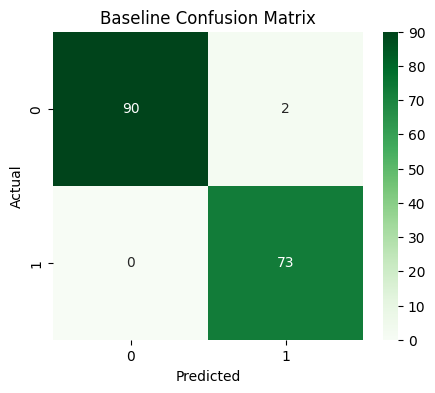

In [99]:
cm2 = confusion_matrix(y_valid, y_pred_imp)
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()

Как видно из результатов, Сильно лучше не стало, но было достигнуто в 100% предсказаний TP/(TP + FN)

## Реализованная модель

In [100]:
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

# Best split search
def best_split(X, y):
    best_feature = None
    best_threshold = None
    best_gain = -1
    parent_entropy = entropy(y)

    n_features = X.shape[1]

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for t in thresholds:
            left = y[X[:, feature] <= t]
            right = y[X[:, feature] > t]
            if len(left) == 0 or len(right) == 0:
                continue

            gain = parent_entropy - (len(left)/len(y))*entropy(left) - (len(right)/len(y))*entropy(right)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = t

    return best_feature, best_threshold, best_gain

# Decision tree node
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeScratch:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def build(self, X, y, depth):
        if depth >= self.max_depth or len(y) < self.min_samples_split or entropy(y) == 0:
            values, counts = np.unique(y, return_counts=True)
            return Node(value=values[np.argmax(counts)])

        feature, threshold, gain = best_split(X, y)
        if gain == -1:
            values, counts = np.unique(y, return_counts=True)
            return Node(value=values[np.argmax(counts)])

        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold

        left_node = self.build(X[left_idx], y[left_idx], depth + 1)
        right_node = self.build(X[right_idx], y[right_idx], depth + 1)

        return Node(feature, threshold, left_node, right_node)

    def fit(self, X, y):
        self.root = self.build(X, y, 0)

    def predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)

    def predict(self, X):
        return np.array([self.predict_one(x, self.root) for x in X])

In [116]:
X_train_np = X_train.values
y_train_np = y_train.values
X_valid_np = X_valid.values
y_valid_np = y_valid.values

In [117]:
scratch_tree = DecisionTreeScratch()
scratch_tree.fit(X_train_np, y_train_np)
y_pred_scratch = scratch_tree.predict(X_valid_np)

In [118]:
acc_s = accuracy_score(y_valid_np, y_pred_scratch)
prec_s = precision_score(y_valid_np, y_pred_scratch)
rec_s = recall_score(y_valid_np, y_pred_scratch)

In [119]:
print("Accuracy:", acc_s)
print("Precision:", prec_s)
print("Recall:", rec_s)

Accuracy: 0.9939393939393939
Precision: 1.0
Recall: 0.9838709677419355


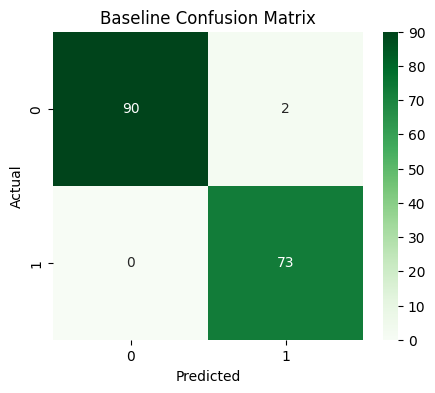

In [120]:
cm3 = confusion_matrix(y_valid, y_pred_scratch)
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()

## Реализованная модель с улучшениями

In [110]:
scratch_tree = DecisionTreeScratch(min_samples_split=2, max_depth=5)
scratch_tree.fit(X_train_np, y_train_np)
y_pred_scratch = scratch_tree.predict(X_valid_np)

In [111]:
acc_s = accuracy_score(y_valid_np, y_pred_scratch)
prec_s = precision_score(y_valid_np, y_pred_scratch)
rec_s = recall_score(y_valid_np, y_pred_scratch)

In [112]:
print("Accuracy:", acc_s)
print("Precision:", prec_s)
print("Recall:", rec_s)

Accuracy: 0.9939393939393939
Precision: 0.9864864864864865
Recall: 1.0


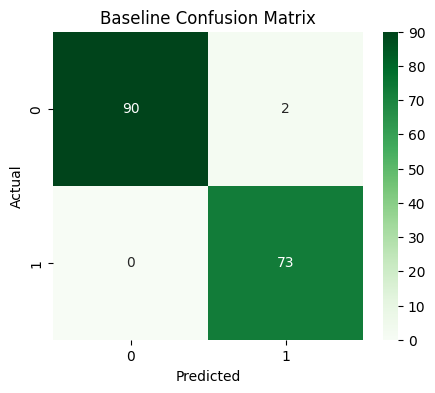

In [114]:
cm3 = confusion_matrix(y_valid, y_pred_scratch)
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()

# Результаты

In [5]:
results_df = pd.DataFrame({
    'Модель': ['Базовая модель', 'Улучшенная модель', 
               'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'Accuracy': [0.9818181818181818, 0.9878787878787879, 
                 0.9939393939393939, 0.9939393939393939],
    'Precision': [0.9682539682539683, 0.9733333333333334, 
                  1.0, 0.9864864864864865],
    'Recall': [0.9838709677419355, 1.0, 
               0.9838709677419355, 1.0]
})


In [6]:
results_df

,Модель,Accuracy,Precision,Recall
0,Базовая модель,0.981818,0.968254,0.983871
1,Улучшенная модель,0.987879,0.973333,1.000000
2,Реализованная базовая модель,0.993939,1.000000,0.983871
3,Улучшенная реализованная модель,0.993939,0.986486,1.000000
